In [1]:
%run ../../_setup.py
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
from skimage import measure
import numpy as np

def contour_length(xr_ds, contour, var=None, timemean=True, time_sel=slice(None, None), lon_sel=slice(None, None), lat_sel=slice(None, None), transform=None):

    field = xr_ds[var] if var is not None else xr_ds.copy()
    
    # take the time mean field
    if timemean and time_sel != slice(None, None):
        field = field.sel(time=time_sel).mean(axis=0)
    elif timemean:
        field = field.mean(axis=0)
    elif not timemean:
        pass
    elif time_sel != slice(None, None):
        field = field.sel(time=time_sel)
    else:
        raise ValueError('Field can have a maximum number of 2 dimension but got %s', field.ndim)

    # select spatial area
    ctfield = field.copy()
    if lon_sel != slice(None, None):
        ctfield = ctfield.sel(longitude=lon_sel)
    if lat_sel != slice(None, None):
        ctfield = ctfield.sel(latitude=lat_sel)

    # find longest contour
    contours = measure.find_contours(ctfield, contour)
    contour = max(contours, key=lambda x: len(x))

    lon_ct, lat_ct = contour[:, 1], contour[:, 0]
    lon_ct = np.nanmin(ctfield.longitude) + np.unique(np.diff(ctfield.longitude)) * lon_ct
    lat_ct = np.nanmin(ctfield.latitude) + np.unique(np.diff(ctfield.latitude)) * lat_ct

    # transform polar coordinates to cartesian coordinates
    if transform is not None:
        WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
        x_ct, y_ct = pyproj.transform(WGS84, transform, lon_ct, lat_ct)
    else:
        x_ct, y_ct = lon_ct.copy(), lat_ct.copy()

    #  calculate contour length in meters
    dx, dy = np.diff(x_ct), np.diff(y_ct)
    cl = np.sum(np.sqrt(dx**2 + dy**2))

    return cl, x_ct, y_ct, field


In [3]:
import pyproj
from scipy.interpolate import griddata, UnivariateSpline
from gsw import f, grav

from OceanPy.projections import haversine, rotatexy

def gradient_balance_from_ssh(xr_ds, coord, 
                              var=('adt', 'ugos', 'vgos'), fcor=1e-4, gravity=9.81, transform=None, time=None):
    
    # select which timestep
    if time is not None:
        xr_ds = xr_ds.sel(time=time)
    
    # take Absolute Dynamic Topography and geostrophic velocities from SSH xarray
    adt = xr_ds.adt if hasattr(xr_ds, var[0]) else xr_ds.copy()
    ugos = xr_ds.ugos if hasattr(xr_ds, var[1]) else None
    vgos = xr_ds.vgos if hasattr(xr_ds, var[2]) else None
    
    # check if field dimensions are 2-D
    if adt.ndim != 2:
        raise ValueError('Field can have a maximum number of 2 dimension but got %s', adt.ndim)

    # transform polar in cartesian coordinate system
    if transform is not None:
        WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')
        lnln, ltlt = np.meshgrid(xr_ds.longitude.data, xr_ds.latitude.data)
        xx, yy = pyproj.transform(WGS84, transform, lnln, ltlt)
        x, y = pyproj.transform(WGS84, transform, *coord)
    else:
        xx, yy = np.meshgrid(xr_ds.longitude.data, xr_ds.latitude.data)
        x, y = coord
    dx, dy = np.unique(np.diff(xr_ds.longitude))[0], np.unique(np.diff(xr_ds.latitude))[0]      
    
    # calculate geostrophy parameters
    if transform is not None:
        fcor = f(coord[1])
        gravity = grav(coord[1], p=0)
    
    # interpolate adt to coordinate location
    points = np.array((xx.flatten(), yy.flatten())).T
    adt_flat = adt.data.flatten()
    adt_coord = griddata(points, adt_flat, (x, y))

    # calculate geostrophic velocities at coordinate location    
    if ugos is None or vgos is None:
        adtx = griddata(points, adt_flat, ([x - (dx / 2), x + (dx / 2)], [y, y]))
        adty = griddata(points, adt_flat, ([x, x], [y - (dy / 2), y + (dy / 2)]))
    
        dzetadx = np.diff(adtx) / dx
        dzetady = np.diff(adty) / dy
        ug = -(gravity / fcor) * dzetady
        vg = (gravity / fcor) * dzetadx
    else:
        ugos_flat = ugos.data.flatten()
        vgos_flat = vgos.data.flatten()
        ug = griddata(points, ugos_flat, (x, y))
        vg = griddata(points, vgos_flat, (x, y))
    # if ug is positive, t is positive in x-direction and n in positive y direction
    xpos = True if ug > 0 else False
    ypos = True if vg > 0 else False
    
    # find contour points close to interested data point
    def strictly_increasing(L):
        return all(i0 < i1 for i0, i1 in zip(L, L[1:]))
    def strictly_decreasing(L):
        return all(i0 > i1 for i0, i1 in zip(L, L[1:]))
    
    coords_ct = contour_length(xr_ds=adt, contour=adt_coord, time_sel=time, timemean=False,
                               lon_sel=slice(coord[0] - 2*dx, coord[0] + 2*dx),
                               lat_sel=slice(coord[1] - 2*dy, coord[1] + 2*dy))[1:3]
    if not (strictly_increasing(coords_ct[0]) | strictly_decreasing(coords_ct[0])):
        # TODO: if transform: distance
        idx = np.argsort(np.sqrt((coords_ct[0] - coord[0])**2 + (coords_ct[1] - coord[1])**2))[0:2]
        coords_ct = (np.append(coords_ct[0][idx], coord[0]), np.append(coords_ct[1][idx], coord[1]))
    
    # determine normal/ tangential resolution
    x0 = (xr_ds.longitude.min() + xr_ds.longitude.max()) / 2
    y0 = (xr_ds.latitude.min() + xr_ds.latitude.max()) / 2
    if transform is not None:
        x_ct, y_ct = pyproj.transform(WGS84, transform, *coords_ct)
        dn = haversine([x0 - dx / 2, x0 + dx / 2], [y0 - dy / 2, y0 + dy / 2])[0][0]
    else:
        x_ct, y_ct = coords_ct
        dn = np.sqrt(dx**2 + dy**2)

    # calculate radius of curvature and orientation angle velocity vector
    try: 
        fx = UnivariateSpline(x_ct, y_ct)
    except ValueError:
        print('x is not increasing')
        x_ct, y_ct = [lst for lst in zip(*sorted(zip(x_ct, y_ct), key=lambda pair: pair[0]))]
        try:
            fx = UnivariateSpline(x_ct, y_ct)
            dydx = fx.derivative(1)(x)
            d2ydx2 = fx.derivative(2)(x)
        except:
            dydx = np.gradient(y_ct)[1] / np.gradient(x_ct)[1]
            d2ydx2 = dydx / np.gradient(x_ct)[1]
    else:
        dydx = fx.derivative(1)(x)
        d2ydx2 = fx.derivative(2)(x)
    
    Rcurv = (1 + dydx**2)**(3 / 2) / d2ydx2
    orientation = np.arctan(dydx) if xpos else np.arctan(dydx) + np.pi
    print('dydx: ', dydx, 'Rcurv:', Rcurv, 'orientation: ', orientation)
    
    # determine locations of points normal to interested data point
    xi = np.array([x - dn / 2, x + dn / 2])
    yi = y * np.ones(len(xi))
    ti, ni = zip(*rotatexy(x, y, xi, yi, orientation + (np.pi / 2)))
    
    # interpolate ssh.adt to normal/ tangential points
    adti = griddata(points, adt_flat, (ti, ni))

    # geostrophic speed
    dDdn = np.diff(adti) / dn
    Vg = -(gravity / fcor) * dDdn

    # gradient speed
    hemisphere = 'SH' if fcor < 0 else 'NH'
    root = np.sqrt(((fcor**2 * Rcurv**2) / 4) + (fcor * Rcurv * Vg))
    print(hemisphere, 'Vg', Vg, 'first term', -(fcor * Rcurv / 2), 'root', root)
    print('plus root', -fcor * Rcurv / 2 + root, 'min root', -fcor * Rcurv / 2 - root)
    if hemisphere == 'NH':
        
        if Rcurv > 0 and Vg > 0:
            # regular low
            V = -(fcor * Rcurv / 2) + root
        elif Rcurv < 0 and Vg > 0:
            # regular high
            V = -(fcor * Rcurv / 2) - root
        else:
            V = 5
    elif hemisphere == 'SH':
        
        if Rcurv < 0 and Vg > 0:
            # regular low
            V = -(fcor * Rcurv / 2) + root
        elif Rcurv > 0 and Vg > 0:
            # regular high
            V = -(fcor * Rcurv / 2) - root
#         elif Rcurv < 0 and Vg < 0:
#             # anomolous high
#             V = -(fcor * Rcurv / 2) + root
        else:
            V = 5

    return coords_ct, ti, ni, ug, vg, Vg, V, orientation

In [4]:
# load altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')
ssh = xr.open_dataset(input_file)

UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# select data range
west = 137
south = -52.4
east = 147
north = -48

# select time
timevoy = slice('1998-03-10', '1998-03-28')
it = 11

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north), time=timevoy)
lnln, ltlt = np.meshgrid(ssh.longitude.data, ssh.latitude.data)
xx, yy = pyproj.transform(WGS84, UTM54, lnln, ltlt)

# load ctd data
input_file_ctd = os.path.join(datadir, 'processed', 'ss9802', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file_ctd)

lon_ctd, lat_ctd = ctd['lon'][2:,0], ctd['lat'][2:][:,0]


In [5]:
ic = 45 #7 83 88 88:positive R, 83:negative R
coords = (lon_ctd[ic], lat_ctd[ic])
# coords = (144.1, -48.45)#(146.3, -50.4)#(146, -50.5) 

coords_ct, ti, ni, ugos, vgos, Vg, V, theta = gradient_balance_from_ssh(ssh, coords, time=ssh.time[it], transform=UTM54)

ug = Vg * np.cos(theta)
vg = Vg * np.sin(theta)

ugr = V * np.cos(theta)
vgr = V * np.sin(theta)


dydx:  -0.017064048962857493 Rcurv: 2493.8658752978145 orientation:  -0.01706239300551552
SH Vg [0.13443471] first term 0.13804156108876725 root [nan]
plus root [nan] min root [nan]


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in sqrt


<IPython.core.display.Javascript object>


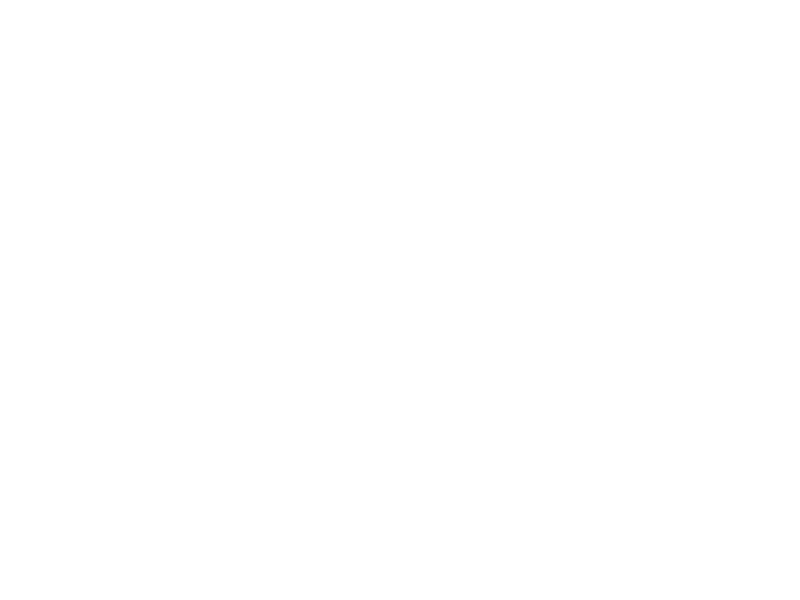

In [6]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 6))
# ax.scatter(*coord)

ax.scatter(*pyproj.transform(WGS84, UTM54, lon_ctd, lat_ctd))
ax.scatter(*pyproj.transform(WGS84, UTM54, *coords_ct), facecolors='orange')
ax.scatter(ti, ni, facecolors='green')
ax.scatter(ti[1], ni[1], facecolors='purple')
ax.quiver(xx, yy, ssh.ugos.sel(time=ssh.time[it]), ssh.vgos.sel(time=ssh.time[it]), 
          units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='k')
ax.quiver(*pyproj.transform(WGS84, UTM54, *coords), ugos, vgos, 
          units='inches', scale=1, width=2e-3*fig.get_size_inches()[0], color='r')
ax.quiver(*pyproj.transform(WGS84, UTM54, *coords), ugr, vgr, 
          units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='b')

# ax.contour(lnln, ltlt, ssh.adt.sel(time=ssh.time[it]), [-0.15, 0, 0.15, 0.3, 0.45], colors='k')
ax.contour(xx, yy, ssh.adt.sel(time=ssh.time[it]), [-0.15, 0, 0.15, 0.3, 0.45], colors='k')
ax.axis('equal')

fig.show()

In [7]:
coords = (lon_ctd, lat_ctd)
Vg = np.empty(len(lon_ctd))
V, theta = Vg.copy(), Vg.copy()
for ic, coord in enumerate(zip(*coords)):
    coords_ct, ti, ni, ugos, vgos, Vg[ic], V[ic], theta[ic] = gradient_balance_from_ssh(ssh, coord, time=ssh.time[it], transform=UTM54)

ug = Vg * np.cos(theta)
vg = Vg * np.sin(theta)

ugr = V * np.cos(theta)
vgr = V * np.sin(theta)

dydx:  -0.519384387281186 Rcurv: 87417.86823775485 orientation:  -0.4790345880935533
SH Vg [0.45274168] first term 5.006055885196099 root [4.53074996]
plus root [9.53680585] min root [0.47530592]
dydx:  -0.5297106851824211 Rcurv: 117671.62756546526 orientation:  -0.4871326840795119
SH Vg [0.43412495] first term 6.7202411436727525 root [6.27110774]
plus root [12.99134888] min root [0.4491334]
dydx:  -0.4756733035517134 Rcurv: -157628.4968144695 orientation:  -0.4439975483202076
SH Vg [0.45499531] first term -8.977973769806406 root [9.42198943]
plus root [0.44401566] min root [-18.3999632]
dydx:  -0.47048992400573664 Rcurv: 761187.2876209058 orientation:  -0.4397620926217939
SH Vg [0.49068747] first term 43.23060714606905 root [42.73710285]
plus root [85.96770999] min root [0.4935043]
dydx:  -0.39443105439869947 Rcurv: 77804.52641906281 orientation:  -0.37569636216606817
SH Vg [0.49538382] first term 4.405938361545914 root [3.87905036]
plus root [8.28498872] min root [0.526888]
dydx:  -0

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


dydx:  -0.788300500707116 Rcurv: 293080.56390880287 orientation:  -0.6675662772630621
SH Vg [0.51019992] first term 16.569320370537117 root [16.05101386]
plus root [32.62033423] min root [0.51830652]
dydx:  -0.6638047841169151 Rcurv: 393381.09774101083 orientation:  -0.5860186823435695
SH Vg [0.49229658] first term 22.29179484229342 root [21.7939388]
plus root [44.08573365] min root [0.49785604]
dydx:  -0.5154885298679536 Rcurv: 234333.49452692337 orientation:  -0.47596151687373156
SH Vg [0.48507921] first term 13.30824937935713 root [12.81399201]
plus root [26.12224139] min root [0.49425737]
dydx:  -0.49874317507728005 Rcurv: -780051.8425818931 orientation:  -0.4626416436728758
SH Vg [0.49044826] first term -44.42150827359078 root [44.90927855]
plus root [0.48777028] min root [-89.33078682]
dydx:  -0.5835071987187784 Rcurv: -120949.31687005729 orientation:  -0.5282041620063428
SH Vg [0.49992383] first term -6.9071910868843895 root [7.39022513]
plus root [0.48303405] min root [-14.2974

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


dydx:  -0.6670378774068275 Rcurv: -147092.86713846572 orientation:  -0.5882595515703928
SH Vg [0.49531915] first term -8.423818951796253 root [8.90537385]
plus root [0.4815549] min root [-17.3291928]
dydx:  -0.002768507164053885 Rcurv: -110929.75659475684 orientation:  -0.0027685000908902885
SH Vg [0.35600638] first term -6.332621511033254 root [6.67914684]
plus root [0.34652533] min root [-13.01176836]
dydx:  -0.30323572194899173 Rcurv: -178040.78532361297 orientation:  -0.29442269668957605
SH Vg [0.38085334] first term -10.132304311069456 root [10.50625693]
plus root [0.37395261] min root [-20.63856124]
dydx:  -0.5368771427218695 Rcurv: -115748.8662217505 orientation:  -0.4927122865604881
SH Vg [0.39110828] first term -6.570210684663497 root [6.95032345]
plus root [0.38011276] min root [-13.52053413]
dydx:  -0.5542249981573572 Rcurv: -232528.21052272434 orientation:  -0.5060811834088278
SH Vg [0.39181452] first term -13.16488090928087 root [13.55103215]
plus root [0.38615124] min roo

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal n

dydx:  -3.8213781376752025 Rcurv: -126324.57167279115 orientation:  -1.3148499585045088
SH Vg [0.2236578] first term -7.05140942220838 root [7.27162844]
plus root [0.22021902] min root [-14.32303787]
dydx:  -2.478490370810601 Rcurv: 152304.0342389088 orientation:  -1.18730094331299
SH Vg [0.25082798] first term 8.517583332188087 root [8.26294919]
plus root [16.78053252] min root [0.25463414]
dydx:  -1.441197490328059 Rcurv: 289246.3416806955 orientation:  -0.9641980494008238
SH Vg [0.32574601] first term 16.21721328631764 root [15.88812832]
plus root [32.10534161] min root [0.32908496]
dydx:  -1.0947215385187379 Rcurv: 140690.93647503492 orientation:  -0.8305865354811923
SH Vg [0.36882998] first term 7.906216452312347 root [7.52835701]
plus root [15.43457346] min root [0.37785944]
dydx:  -1.0363020152271296 Rcurv: 84277.75953784281 orientation:  -0.8032236970805767
SH Vg [0.35329307] first term 4.747925698727521 root [4.38040865]
plus root [9.12833435] min root [0.36751705]
dydx:  -0.8

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


dydx:  -0.7414624230057036 Rcurv: 92632.69490860726 orientation:  -0.6380146305517024
SH Vg [0.29564494] first term 5.243725159309979 root [4.93924002]
plus root [10.18296517] min root [0.30448514]
dydx:  -0.7406291774087388 Rcurv: 27574.98709024206 orientation:  -0.6374767573867652
SH Vg [0.25375748] first term 1.564494375321284 root [1.28593871]
plus root [2.85043308] min root [0.27855567]
dydx:  -0.6069959046673638 Rcurv: 58233.99990215556 orientation:  -0.5455476749822793
SH Vg [0.2100179] first term 3.311547769595556 root [3.09441109]
plus root [6.40595886] min root [0.21713668]
dydx:  -0.9258031906613283 Rcurv: -33920.3402857061 orientation:  -0.746889488086243
SH Vg [0.19148576] first term -1.9200440822595437 root [2.1028294]
plus root [0.18278532] min root [-4.02287348]
dydx:  -0.31138676459099773 Rcurv: -49644.24339990261 orientation:  -0.3018703540746503
SH Vg [0.13088766] first term -2.8047561615947916 root [2.93272451]
plus root [0.12796835] min root [-5.73748068]
dydx:  -0

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


dydx:  -0.017064048962857493 Rcurv: 2493.8658752978145 orientation:  -0.01706239300551552
SH Vg [0.13443471] first term 0.13804156108876725 root [nan]
plus root [nan] min root [nan]
dydx:  -0.6318154141482566 Rcurv: 34062.75732492268 orientation:  -0.5634852820742654
SH Vg [0.21889159] first term 1.8878583568226486 root [1.65455025]
plus root [3.5424086] min root [0.23330811]
dydx:  -0.847996312632118 Rcurv: 60166.079409882266 orientation:  -0.7033296697095252
SH Vg [0.28107348] first term 3.3389233647258356 root [3.04490453]
plus root [6.3838279] min root [0.29401883]
dydx:  -1.7054625372011423 Rcurv: -193688.26669826952 orientation:  -1.040473165545253
SH Vg [0.32574661] first term -10.761003290859797 root [11.08196338]
plus root [0.32096009] min root [-21.84296667]
dydx:  -1.5244388326721423 Rcurv: -840247.8863095442 orientation:  -0.9902293555590695


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in sqrt


SH Vg [0.34616505] first term -46.74335028840985 root [47.08824296]
plus root [0.34489267] min root [-93.83159325]
dydx:  -1.2420671824226897 Rcurv: -94630.49732271522 orientation:  -0.892947634892232
SH Vg [0.36855879] first term -5.27066277391788 root [5.62716485]
plus root [0.35650208] min root [-10.89782763]
dydx:  -1.1749778033272988 Rcurv: -49285.99589236246 orientation:  -0.8656756546937469
SH Vg [0.31285805] first term -2.750749822033148 root [3.04759135]
plus root [0.29684153] min root [-5.79834117]
dydx:  -0.8763869616296547 Rcurv: -40048.96499022363 orientation:  -0.719614995688325
SH Vg [0.23299784] first term -2.239749520093008 root [2.46174562]
plus root [0.2219961] min root [-4.70149514]
dydx:  -1.090732659431773 Rcurv: -118844.87051124139 orientation:  -0.8287684924304298
SH Vg [0.1311631] first term -6.661147576898065 root [6.79104415]
plus root [0.12989657] min root [-13.45219172]
dydx:  -0.8377996326073148 Rcurv: 204569.78520052094 orientation:  -0.6973683418249513
S

dydx:  0.13392588063610744 Rcurv: 145062.88148014902 orientation:  0.13313368417216467
SH Vg [0.35232475] first term 8.065770432546591 root [7.70539497]
plus root [15.7711654] min root [0.36037546]
dydx:  0.3386298906321325 Rcurv: -292900.5709428857 orientation:  0.3265098575972325
SH Vg [0.41817917] first term -16.321627744897643 root [16.73458281]
plus root [0.41295507] min root [-33.05621056]
dydx:  0.5756931763940308 Rcurv: 243226.7811777741 orientation:  0.5223550642269787
SH Vg [0.43422614] first term 13.583901400322235 root [13.14250384]
plus root [26.72640524] min root [0.44139756]
dydx:  0.9152933643876626 Rcurv: -57148.032084338985 orientation:  0.7412005100412381
SH Vg [0.34396018] first term -3.198810911928414 root [3.52603438]
plus root [0.32722346] min root [-6.72484529]
dydx:  0.578746009647255 Rcurv: -298474.62468435377 orientation:  0.5246449482807339
SH Vg [0.19292371] first term -16.742022469978206 root [16.93384725]
plus root [0.19182478] min root [-33.67586972]
dyd

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:227: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


<IPython.core.display.Javascript object>


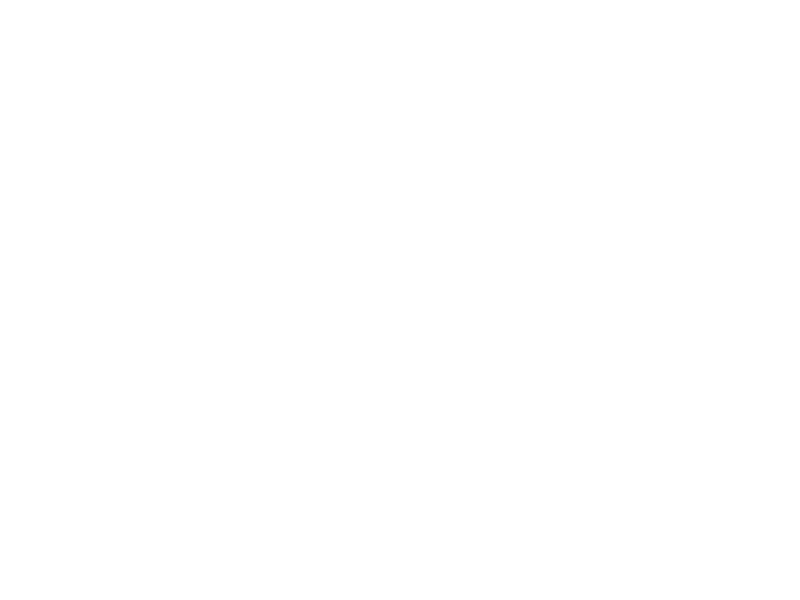

In [8]:
%matplotlib notebook
fig, ax = plt.subplots(figsize=(8, 6))

ax.contour(ssh.longitude, ssh.latitude, ssh.adt.sel(time=ssh.time[it]), [-0.15, 0, 0.15, 0.3, 0.45], colors='k')
quiv = ax.quiver(ssh.longitude, ssh.latitude, ssh.ugos.sel(time=ssh.time[it]), ssh.vgos.sel(time=ssh.time[it]), 
                 units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='k')
quiv2 = ax.quiver(*coords, ug, vg, units='inches', scale=1, width=4e-3*fig.get_size_inches()[0], color='r')
quiv2 = ax.quiver(*coords, ugr, vgr, units='inches', scale=1, width=2e-3*fig.get_size_inches()[0], color='b')

plt.quiverkey(quiv, 0.9, 0.95, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'medium'})
plt.quiverkey(quiv2, 0.9, 0.9, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'medium'})

<IPython.core.display.Javascript object>


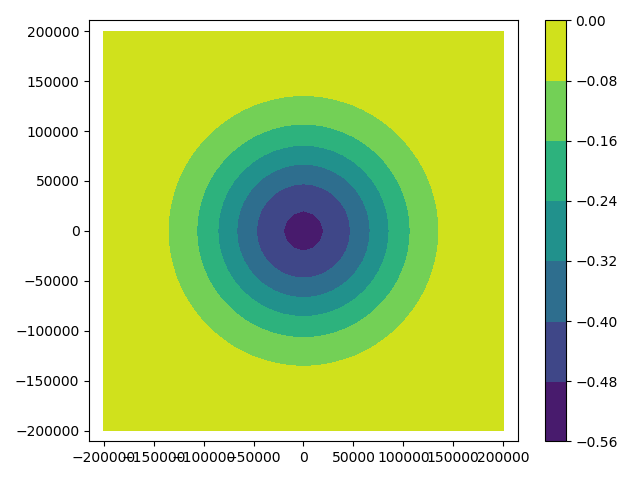

In [13]:
%matplotlib notebook
# define grid
nx, ny = 41, 41
lx, ly = 2e5, 2e5
xi, dx = np.linspace(-lx, lx, nx, retstep=True)
yi, dy = np.linspace(-ly, ly, ny, retstep=True)
# dx, dy = Lx / (nx - 1), Ly / (ny - 1)
xx, yy = np.meshgrid(xi, yi)
xc, yc = xi[0] + (nx - 1) * dx / 2, yi[0] + (ny - 1) * dy / 2
amp, a, b, = 0.5, 1e-10, 1e-10
z = -amp * np.exp(-a*(xx - xc)**2 - b*(yy-yc)**2)

fig, ax = plt.subplots()
cf = ax.contourf(xx, yy, z)
fig.colorbar(cf)
ax.axis('equal')
fig.tight_layout()


In [14]:
field = xr.DataArray(z, dims=['latitude', 'longitude'], coords=[yi, xi])

In [15]:
loc = 100000
fcor = -1e-4
# ----------------

# coords = (loc, loc)
# coords_ct, ti, ni, ugos, vgos, Vg, V, theta = gradient_balance_from_ssh(field, coords)

# ----------------
coords = ([0, loc, loc, loc, -loc, -loc], [loc, 0, loc, -loc, -loc, loc])
# coords = ([loc], [loc])
Vg = np.empty(len(coords[0]))
V, theta = Vg.copy(), Vg.copy()
for ic, coord in enumerate(zip(*coords)):
    coords_ct, ti, ni, ugos, vgos, Vg[ic], V[ic], theta[ic] = gradient_balance_from_ssh(field, coord, fcor=fcor)

# ----------------

ug = Vg * np.cos(theta)
vg = Vg * np.sin(theta)

ugr = V * np.cos(theta)
vgr = V * np.sin(theta)

dydx:  3.823330541052883e-15 Rcurv: -104598.66079334247 orientation:  3.823330541052883e-15
SH Vg [0.35968558] first term -5.229933039667124 root [5.57803394]
plus root [0.3481009] min root [-10.80796698]
x is not increasing
dydx:  -20.82050934127055 Rcurv: -104462.97610501651 orientation:  1.6187890103460656
SH Vg [-0.35927143] first term -5.223148805250826 root [4.8505904]
plus root [-0.37255841] min root [-10.0737392]
dydx:  -0.995618087197423 Rcurv: -241208.36755467986 orientation:  -0.783202399694764
SH Vg [0.1871296] first term -12.060418377733994 root [12.24611833]
plus root [0.18569995] min root [-24.3065367]
x is not increasing
dydx:  0.995618087197423 Rcurv: 241208.36755467986 orientation:  3.9247950532845572
SH Vg [0.1871296] first term 12.060418377733994 root [11.87181405]
plus root [23.93223243] min root [0.18860433]
x is not increasing
dydx:  -0.9956180857052356 Rcurv: 241208.38955040302 orientation:  2.3583902546443993
SH Vg [0.1871296] first term 12.060419477520151 root

<IPython.core.display.Javascript object>


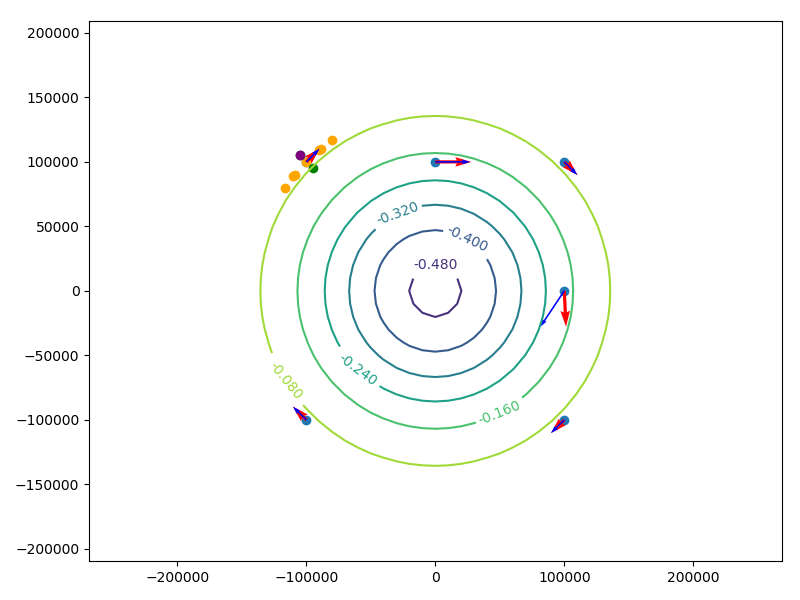

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ct = ax.contour(field.longitude, field.latitude, field)
ax.clabel(ct)
ax.scatter(*coords)
ax.scatter(*zip(coords_ct), facecolors='orange')
ax.scatter(ti, ni, facecolors='green')
ax.scatter(ti[1], ni[1], facecolors='purple')
plt.quiver(*coords, ug, vg, units='inches', scale=1, width=4e-3*fig.get_size_inches()[0], color='r')
plt.quiver(*coords, ugr, vg, units='inches', scale=1, width=2e-3*fig.get_size_inches()[0], color='b')

ax.axis('equal')
fig.tight_layout()
